In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import sys, re, json, os, datetime
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

## Exploratory analyses of Spotify MPD

![An example playist](img/playlist.png)

An example of a Spotify playlist.

### Dataset structure

The data is structured in arrays that typically contains 1,000 playlists. Each playlist is a dictionary that contains the following fields:

+ **pid** - integer - playlist id - the MPD ID of this playlist. This is an integer between 0 and 999,999.
+ **name** - string - the name of the playlist
+ **description** - optional string - if present, the description given to the playlist. Note that user-provided playlist descrptions are a relatively new feature of Spotify, so most playlists do not have descriptions.
+ **modified_at** - seconds - timestamp (in seconds since the epoch) when this playlist was last updated. Times are rounded to midnight GMT of the date when the playlist was last updated.
+ **num_artists** - the total number of unique artists for the tracks in the playlist.
+ **num_albums** - the number of unique albums for the tracks in the playlist
+ **num_tracks** - the number of tracks in the playlist
+ **num_followers** - the number of followers this playlist had at the time the MPD was created. (Note that the follower count does not including the playlist creator)
+ **num_edits** - the number of separate editing sessions. Tracks added in a two hour window are considered to be added in a single editing session.
+ **duration_ms** - the total duration of all the tracks in the playlist (in milliseconds)
+ **collaborative** - boolean - if true, the playlist is a collaborative playlist. Multiple users may contribute tracks to a collaborative playlist.
+ **tracks** - an array of information about each track in the playlist. Each element in the array is a dictionary with the following fields:
    - **track_name** - the name of the track
    - **track_uri** - the Spotify URI of the track
    - **album_name** - the name of the track's album
    - **album_uri** - the Spotify URI of the album
    - **artist_name** - the name of the track's primary artist
    - **artist_uri** - the Spotify URI of track's primary artist
    - **duration_ms** - the duration of the track in milliseconds
    - **pos** - the position of the track in the playlist (zero-based)
    
### Some questions to guide my exploratory analyses

1. This dataset was collected between January 2010 to October 2017. What were the top tracks, artists, and genres (measured through playlist titles) at this time?

2. Are there natural patterns that fall out of clustering existing playlists? For example, are there playlist-level differences between different genre-specific playlists (such as rock, rap, classical) or "mood" playlists (happy, sad, studying)?

3. Are there any differences between collaborative and "personal" playlists?

Note that I removed the failed tests from the show and tell- you can see these in checkpoint.ipynb.

In [2]:
%%time 
total_playlists = 0
total_tracks = 0
tracks = set()
artists = set()
albums = set()
titles = set()
total_descriptions = 0
ntitles = set()
title_histogram = Counter()
artist_histogram = Counter()
track_histogram = Counter()
last_modified_histogram = Counter()
num_edits_histogram = Counter()
playlist_length_histogram = Counter()
num_followers_histogram = Counter()

def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            mpd_slice = json.loads(js)
            process_info(mpd_slice['info'])
            for playlist in mpd_slice['playlists']:
                process_playlist(playlist)
            count += 1

def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[.,\/#!$%\^\*;:{}=\_`~()@-]", ' ', name)
    name = re.sub(r"&", 'and', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

def to_date(epoch):
    return datetime.datetime.fromtimestamp(epoch).strftime("%Y-%m-%d")

def process_playlist(playlist):
    global total_playlists, total_tracks, total_descriptions

    total_playlists += 1
    # print playlist['playlist_id'], playlist['name']

    if 'description' in playlist:
        total_descriptions += 1

    titles.add(playlist['name'])
    nname = normalize_name(playlist['name'])
    ntitles.add(nname)
    title_histogram[nname] += 1

    playlist_length_histogram[playlist['num_tracks']] += 1
    last_modified_histogram[playlist['modified_at']] += 1
    num_edits_histogram[playlist['num_edits']] += 1
    num_followers_histogram[playlist['num_followers']] += 1

    for track in playlist['tracks']:
        total_tracks += 1
        albums.add(track['album_uri'])
        tracks.add(track['track_uri'])
        artists.add(track['artist_uri'])

        full_name = track['track_name'] + " by " + track['artist_name']
        artist_histogram[track['artist_name']] += 1
        track_histogram[full_name] += 1


def process_info(_):
    pass

path = '../mpd.v1/data'
process_mpd(path)

CPU times: user 6min 45s, sys: 23.3 s, total: 7min 8s
Wall time: 7min 15s


### Question 1a

This dataset was collected between January 2010 to October 2017. What were the top tracks, artists, and genres (measured through playlist titles) at this time?

In [3]:
print ("number of playlists", total_playlists)
print ("number of tracks", total_tracks)
print ("number of unique tracks", len(tracks))
print ("number of unique albums", len(albums))
print ("number of unique artists", len(artists))
print ("number of unique titles", len(titles))
print ("number of playlists with descriptions", total_descriptions)
print ("number of unique normalized titles", len(ntitles))
print ("avg playlist length", float(total_tracks) / total_playlists)

number of playlists 1000000
number of tracks 66346428
number of unique tracks 2262292
number of unique albums 734684
number of unique artists 295860
number of unique titles 92944
number of playlists with descriptions 18760
number of unique normalized titles 17266
avg playlist length 66.346428


In [4]:
print ("top playlist titles")
for title, count in title_histogram.most_common(20):
    print ("%7d %s" % (count, title))

print ('\n')
print ("top tracks")
for track, count in track_histogram.most_common(20):
    print ("%7d %s" % (count, track))

print ('\n')
print ("top artists")
for artist, count in artist_histogram.most_common(20):
    print ("%7d %s" % (count, artist))

top playlist titles
  10000 country
  10000 chill
   8493 rap
   8481 workout
   8146 oldies
   8015 christmas
   6848 rock
   6157 party
   5883 throwback
   5063 jams
   5052 worship
   4907 summer
   4677 feels
   4612 new
   4186 disney
   4124 lit
   4030 throwbacks
   3886 music
   3513 sleep
   3500 vibes


top tracks
  46574 HUMBLE. by Kendrick Lamar
  43447 One Dance by Drake
  41309 Broccoli (feat. Lil Yachty) by DRAM
  41079 Closer by The Chainsmokers
  39987 Congratulations by Post Malone
  35202 Caroline by Aminé
  35138 iSpy (feat. Lil Yachty) by KYLE
  34999 Bad and Boujee (feat. Lil Uzi Vert) by Migos
  34990 Location by Khalid
  34922 XO TOUR Llif3 by Lil Uzi Vert
  33699 Bounce Back by Big Sean
  32391 Ignition - Remix by R. Kelly
  32336 No Role Modelz by J. Cole
  32059 Mask Off by Future
  31492 No Problem (feat. Lil Wayne & 2 Chainz) by Chance The Rapper
  31374 I'm the One by DJ Khaled
  31119 Jumpman by Drake
  31106 goosebumps by Travis Scott
  30678 Fake Love 

### Question 1b

Let's also look at the distribution of number of edits, playlist length, and number of followers, and see if there are any interesting patterns there.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


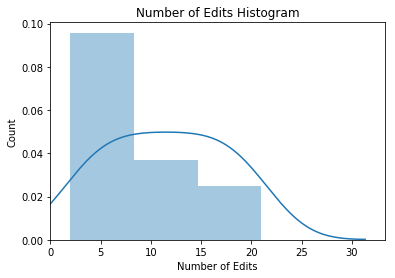

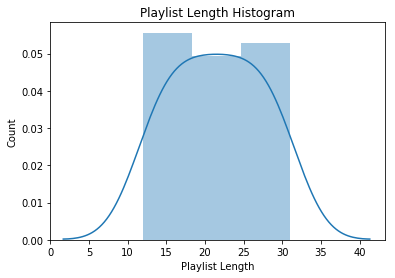

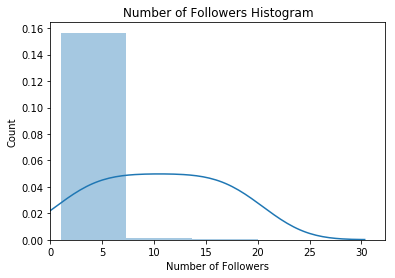

In [5]:
def show_histogram(hist, num, var):
    common = np.array(hist.most_common(num))
    sns.distplot(common[:,0], hist_kws={"weights":common[:,1]})

    plt.xlim(0, None)
    plt.title(var)
    plt.xlabel(' '.join(var.split()[:-1]))
    plt.ylabel('Count')

    plt.show()
    
show_histogram(num_edits_histogram, 20, 'Number of Edits Histogram')
show_histogram(playlist_length_histogram, 20, 'Playlist Length Histogram')
show_histogram(num_followers_histogram, 20, 'Number of Followers Histogram')

Most people edit their playlists less than about 10 times. This makes sense, as each "edit" is a two-hour window of adding/removing songs, and most people just create an entirely new playlist instead of continually editing over the span of weeks or months. Additionally, most people have playlists that are between 15 and 30 songs in length, resulting in playlists that are about 90 minutes to 2 hours long. Additionally, he vast majority of playlists have 5 or fewer followers. Most playlists are quite personal and may serve to capture the specific songs of genre or mood that the user actually likes.

### Question 2

Are there natural patterns that fall out of clustering existing playlists? For example, are there playlist-level differences between different genre-specific playlists (such as rock, rap, classical) or "mood" playlists (happy, sad, studying)?

I'm going to look a few genres/moods: rock, rap/hip-hop, classical, pop, R&B, country, guilty pleasures, cardio/workout, party, happy, sad, studying, and angsty. I want to see if any natural clusters fall out of these genres.

In [14]:
%%time
def make_genre_df(path, num_slices, genres):
    df_list = [[] for _ in range(len(genres))]
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        if count < num_slices and filename.startswith("mpd.slice.") and filename.endswith(".json"):
            if count % 100 == 0:
                print(count)
            fullpath = os.sep.join((path, filename))
            data = json.load(open(fullpath))
            slice_df = json_normalize(data, 'playlists')
            slice_df['normalized_name'] = slice_df['name'].apply(lambda x: normalize_name(x))
            for i, genre in enumerate(genres):
                genre_df = slice_df[slice_df['normalized_name'].str.match(genre)]
                genre_df['genre'] = i
                df_list[i].append(genre_df)
            count += 1
    df_list = [pd.concat(genre_df) for genre_df in df_list]
    return pd.concat(df_list)

path = '../mpd.v1/data'
genres = ['rock', '(?:rap|hip hop)', 'classical', 'pop', '(?:r and b|rhythm and blues)', 'country', 'guilty pleasures', '(?:cardio|workout)', 'party', 'happy', 'sad', 'angst', 'study']
genre_df = make_genre_df(path, 1000, genres)

0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


100
200
300
400
500
600
700
800
900
CPU times: user 42min 47s, sys: 41.3 s, total: 43min 28s
Wall time: 1h 6min 16s


In [15]:
genre_df.head()

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,pid,tracks,normalized_name,genre
168,false,NaN,2792225,1432512000,Rock alternativo,11,9,3,1,12,168,"[{'pos': 0, 'artist_name': 'Green Day', 'track...",rock alternativo,0
417,false,NaN,4516482,1491436800,Rock,8,6,4,1,17,417,"[{'pos': 0, 'artist_name': 'Starset', 'track_u...",rock,0
543,false,NaN,23420250,1439078400,Rock,74,66,22,1,87,543,"[{'pos': 0, 'artist_name': 'Pearl Jam', 'track...",rock,0
580,false,NaN,12819026,1487462400,rock,45,36,4,1,48,580,"[{'pos': 0, 'artist_name': 'Third Eye Blind', ...",rock,0
634,false,NaN,13777908,1508025600,ROCK🎸,51,41,26,3,56,634,"[{'pos': 0, 'artist_name': 'Don McLean', 'trac...",rock🎸,0


In [23]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

feature_cols = ['duration_ms', 'num_albums', 'num_artists', 'num_edits', 'num_followers', 'num_tracks', 'collaborative']
genre_df = genre_df.replace({'collaborative': {'false':0, 'true':1}})
genre_df[feature_cols] = genre_df[feature_cols].apply(pd.to_numeric, errors='coerce')

data = genre_df[feature_cols]
labels = genre_df['genre']
n_genres = genre_df['genre'].nunique()

print('There are {0} genres.'.format(n_genres))
data.head()

There are 13 genres.


,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks,collaborative
168,2792225,11,9,3,1,12,0
417,4516482,8,6,4,1,17,0
543,23420250,74,66,22,1,87,0
580,12819026,45,36,4,1,48,0
634,13777908,51,41,26,3,56,0


In [29]:
model = KMeans(n_clusters=n_genres, random_state=0)
model.fit(data)

model_metrics = metrics.precision_recall_fscore_support(labels, model.labels_)

print('precision: {0}'.format(model_metrics[0]))
print('recall: {0}'.format(model_metrics[1]))
print('f-score: {0}'.format(model_metrics[2]))

precision: [0.12807882 0.23878437 0.02143433 0.05471677 0.00357498 0.14612106
 0.00526946 0.08544839 0.10070347 0.04574163 0.01048066 0.00365755
 0.15      ]
recall: [0.13278154 0.05460683 0.05371567 0.09482589 0.07531381 0.10249357
 0.04081633 0.00899136 0.12023005 0.11616039 0.00722832 0.07377049
 0.00154759]
f-score: [0.13038779 0.08888649 0.03064163 0.06939246 0.00682594 0.12047939
 0.0093339  0.01627064 0.10960386 0.0656368  0.00855583 0.00696954
 0.00306357]


Looking at the f-scores of my genre kmeans clustering model, it seems that there are not playlist-level features (besides name, of course) that differentiate playlists from different genres. However, the rock, country, and party genres had the highest f-scores (of 0.13, 0.12, and 0.11, respectively) out of all of the genres. This surprised me, as I thought that genres like studying or classical would have more distinguishing features, as they tend to be longer, and I would think that they'd have more followers (Who wants to make a 5 hour playlist of background studying music? Not me).

I was going to visual this clustering with PCA (to reduce feature dim), but my computer ran out of memory and my kernel died. To avoid having to load the genre dataframe again and destroying my computer, I'm going to end this analysis here. I've left my visualization code below if you'd like to give it a go. I think in the future it would be interesting to see if any genres naturally cluster together - for example, maybe rock and angst, classical and studying, or happy and pop might cluster together. 

In [ ]:
# I run into memory errors oh no
# I tried to clear the genre df, but that killed my kernel
# del genre_df

# reduce the data w PCA for visualization
reduced_data = PCA(n_components=2).fit_transform(data)
model = KMeans(n_clusters=n_genres, random_state=0)
model.fit(reduced_data)

# step size of the mesh, decrease to increase the quality of the VQ
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# plot the decision boundary
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# get labels for each point in mesh
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# put the result into a colored scatterplot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# plot the cluster means
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=100, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on playlist genres (PCA-reduced data)\n'
          'Cluster means are marked with white X')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Question 3

Are there any differences between collaborative and "personal" playlists? I hypothesize that collaborative playlists will have a greater diversity of artists, have more edits, and have more followers than personal playlists.

In [2]:
%%time
def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[.,\/#!$%\^\*;:{}=\_`~()@-]", ' ', name)
    name = re.sub(r"&", 'and', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

def make_social_df(path, num_slices, cutoff):
    df_list = []
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        if count < num_slices and filename.startswith("mpd.slice.") and filename.endswith(".json"):
            if count % 100 == 0:
                print(count)
            fullpath = os.sep.join((path, filename))
            data = json.load(open(fullpath))
            slice_df = json_normalize(data, 'playlists')
            slice_df['normalized_name'] = slice_df['name'].apply(lambda x: normalize_name(x))
            popular_df = slice_df[slice_df['num_followers'] >= cutoff]
            df_list.append(popular_df)
            count += 1
    return pd.concat(df_list)

path = '../mpd.v1/data'
social_df = make_social_df(path, 1000, 5)

0
100
200
300
400
500
600
700
800
900
CPU times: user 3min 49s, sys: 27.4 s, total: 4min 17s
Wall time: 4min 25s


In [2]:
feature_cols = ['duration_ms', 'num_albums', 'num_artists', 'num_edits', 'num_followers', 'num_tracks', 'collaborative']
social_df = social_df.replace({'collaborative': {'false':0, 'true':1}})
social_df[feature_cols] = social_df[feature_cols].apply(pd.to_numeric, errors='coerce')
print(social_df.shape)

(29651, 13)


Note that I am only looking at playlists with more than 5 followers. Since I'm mostly looking at the social aspect of playlist creation here, I want to focus on playlists with more social engagement. Let's see what the playlists with the most followers, artists, and edits are!

In [5]:
social_df.sort_values(by=['num_followers'], ascending=False).head()

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,pid,tracks,normalized_name
269,0,NaN,10567634,1491523200,That's What I Like,37,31,7,71643,39,248269,"[{'pos': 0, 'artist_name': 'Bruno Mars', 'trac...",that's what i like
359,0,Every song ever featured on Breaking Bad!,23561532,1381104000,Breaking Bad,102,101,26,53519,106,746359,"[{'pos': 0, 'artist_name': 'Badfinger', 'track...",breaking bad
472,0,NaN,27955610,1509062400,One Tree Hill,85,78,8,45942,111,399472,"[{'pos': 0, 'artist_name': 'Audioslave', 'trac...",one tree hill
831,0,NaN,11824924,1478908800,My Little Pony,9,25,6,31539,85,180831,"[{'pos': 0, 'artist_name': 'Applebloom', 'trac...",my little pony
740,0,"Jack's <a href=""http://instagram.com/thatsojac...",18541204,1458604800,Q1,75,72,63,27830,81,720740,"[{'pos': 0, 'artist_name': 'dvsn', 'track_uri'...",q1


In [6]:
social_df.sort_values(by=['num_artists'], ascending=False).head()

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,pid,tracks,normalized_name
712,0,NaN,59649777,1455753600,90s,239,238,16,10,240,544712,"[{'pos': 0, 'artist_name': '4 Non Blondes', 't...",90s
816,0,NaN,67066064,1504483200,Best,239,225,37,5,243,749816,"[{'pos': 0, 'artist_name': 'Mulatu Astatke', '...",best
827,0,The ultimate chill pill. Kick back and unwind.,62662727,1508803200,Chillstep,239,224,52,7,246,683827,"[{'pos': 0, 'artist_name': 'NGB Dubstep', 'tra...",chillstep
863,0,NaN,57780667,1367366400,Spring 2013,226,223,3,5,243,132863,"[{'pos': 0, 'artist_name': 'Waxahatchee', 'tra...",spring 2013
260,0,NaN,55730856,1454112000,2014,227,223,53,13,245,611260,"[{'pos': 0, 'artist_name': 'Grimes', 'track_ur...",2014


In [7]:
social_df.sort_values(by=['num_edits'], ascending=False).head()

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,pid,tracks,normalized_name
214,0,NaN,55177026,1508803200,ATL,178,143,197,18,234,590214,"[{'pos': 0, 'artist_name': 'Phoenix', 'track_u...",atl
857,1,NaN,56530730,1499644800,The Crew,218,186,197,7,242,763857,"[{'pos': 0, 'artist_name': 'Neutral Milk Hotel...",the crew
169,0,NaN,60780455,1503014400,slow,212,156,191,7,238,729169,"[{'pos': 0, 'artist_name': 'Jeremih', 'track_u...",slow
192,0,NaN,55871123,1506816000,Good Stuff,198,144,191,8,232,125192,"[{'pos': 0, 'artist_name': 'Martin Solveig', '...",good stuff
74,0,NaN,76897119,1507593600,Quiet Time,146,99,188,5,236,885074,"[{'pos': 0, 'artist_name': 'All Sons & Daughte...",quiet time


In [25]:
print('There were {0} collaborative playlists.'.format(sum(social_df['collaborative'] == 1)))
print('There were {0} non-collaborative playlists.'.format(sum(social_df['collaborative'] == 0)))

There were 933 collaborative playlists.
There were 28718 non-collaborative playlists.


Let's plot the histogram distributions, split by 'collaborative' class, of the numbers of followers, artists, and edits.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1b780a6d8>,
      dtype=object)

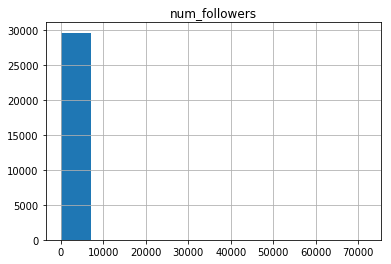

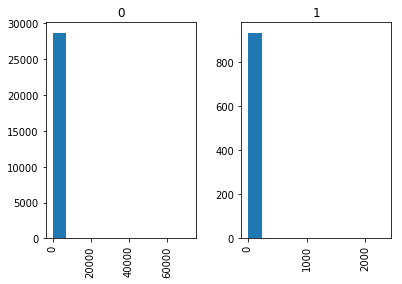

In [11]:
social_df.hist(column='num_followers')
social_df.hist(column='num_followers', by='collaborative')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x19284b0f0>,
      dtype=object)

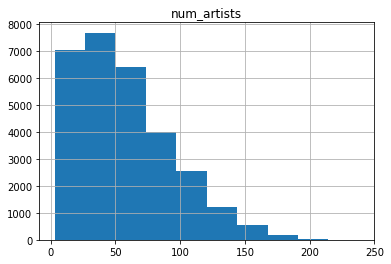

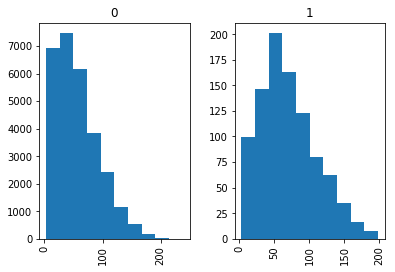

In [12]:
social_df.hist(column='num_artists')
social_df.hist(column='num_artists', by='collaborative')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x17f334940>,
      dtype=object)

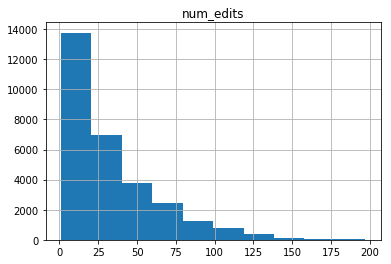

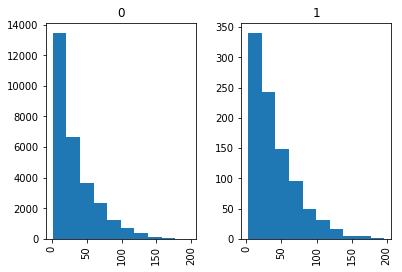

In [13]:
social_df.hist(column='num_edits')
social_df.hist(column='num_edits', by='collaborative')

It looks like collaborative playlists have greater artist diversity and more edits, but not necessarily more followers. Let's see if these differences are statistically significant. I'll first plot some boxplots for each of number of edits, followers, and artists by collaboration class, and then do a Kruskal-Wallis one-way ANOVA to test for statistically significant differences between classes.

Kruskal–Wallis is a non-parametric method to test whether or not the samples are drawn from the same distribution. Since it is a non-parametric method, the Kruskal–Wallis test does not assume a normal distribution of the residuals, unlike regular one-way ANOVA. Here we assume an identically shaped and scaled distribution for all groups, except for any difference in medians, giving us the null hypothesis that the medians of all groups are equal. Note that rejecting the null hypothesis does not indicate which of the groups differs.

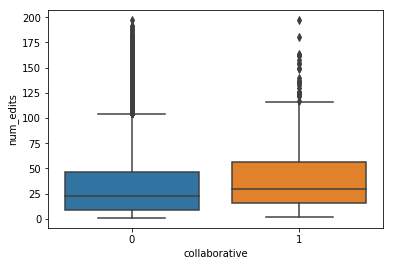

In [20]:
sns.boxplot(x='collaborative', y='num_edits', data=social_df)

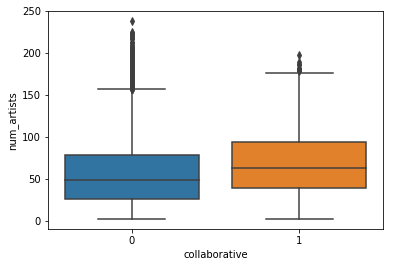

In [21]:
sns.boxplot(x='collaborative', y='num_artists', data=social_df)

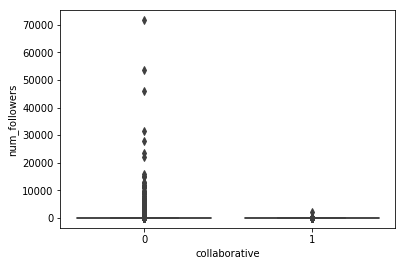

In [22]:
sns.boxplot(x='collaborative', y='num_followers', data=social_df)

In [24]:
import scipy.stats as stats

collab_social_df = social_df[social_df['collaborative'] == 1]
personal_social_df = social_df[social_df['collaborative'] == 0]

print('Statistical significance of edit count difference between collaborative/personal playlists:')
print(stats.kruskal(personal_social_df['num_edits'], collab_social_df['num_edits']))

print('\nStatistical significance of unique artist count difference between collaborative/personal playlists:')
print(stats.kruskal(personal_social_df['num_artists'], collab_social_df['num_artists']))

print('\nStatistical significance of follower count difference between collaborative/personal playlists:')
print(stats.kruskal(personal_social_df['num_followers'], collab_social_df['num_followers']))

Statistical significance of edit count difference between collaborative/personal playlists:
KruskalResult(statistic=69.59346778420476, pvalue=7.287785579459069e-17)

Statistical significance of unique artist count difference between collaborative/personal playlists:
KruskalResult(statistic=112.20338346122699, pvalue=3.224734863213084e-26)

Statistical significance of follower count difference between collaborative/personal playlists:
KruskalResult(statistic=38.907299291392334, pvalue=4.444157539492859e-10)


The Kruskal-Wallis one-way ANOVA showed that there was a statistically significant difference in follower count (χ2(397) = 38.91, p < 0.00001), unique artist count (χ2(397) = 112.20, p < 0.00001), and edit count (χ2(397) = 69.59, p < 0.00001) between the two groups of collaborative vs personal playlists. Therefore, I reject the null hypothesis that the two groups share the same median follower, unique artist, and edit count and conclude that the groups significantly differ.

Looking at the boxplots in combination with the Kruskal-Wallis ANOVAs, we see that collaborative playlists have more edits and unique artists, but fewer followers, than personal playlists. As expected, collaborative playlists have more edits (because more people are working on the same playlist- note, though, that the edit count is **not** double-, triple-, or higher-counting each additional collaborator, as it measures one edit session as one two-hour block when any edits occur in the playlist) and have more diverse artist lists (because different collaborators each contribute unique music tastes and artists to the playlist). Interestingly, collaborative playlists seem to have fewer followers than personal playlists, though this may be because there are many more personal (28718) than collaborative (933) playlists in this dataset.

In light of these results, let's do a cross-validated logistic regression to see if we can predict playlist collaboration from the playlist-level features we've been working with. I'm going to look quickly at the variance inflation factors for these features to see if they're highly correlated (which might cause issues for my log regression model).

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_w_constant = add_constant(social_df[feature_cols])

pd.Series([variance_inflation_factor(df_w_constant.values, i) for i in range(df_w_constant.shape[1])], index=df_w_constant.columns)

const             3.795992
duration_ms      18.742227
num_albums       24.577429
num_artists      12.561705
num_edits         1.885403
num_followers     1.001204
num_tracks       23.130430
collaborative     1.005172
dtype: float64

By looking at the variance inflation factors for the selected features, we can see that the number of albums, artists, tracks, and playlist duration are all highly correlated, with VIFs > 10 (obviously, because playlists with more tracks will be longer, and playlists with more artists will have more albums). I'll remove the playlist length and number of albums features to remove this multicollinearity in my logistic regression model (see below that this eliminates most of the multicollinearity).

In [27]:
feature_cols = ['num_artists', 'num_edits', 'num_followers', 'num_tracks', 'collaborative']

df_w_constant = add_constant(social_df[feature_cols])

pd.Series([variance_inflation_factor(df_w_constant.values, i) for i in range(df_w_constant.shape[1])], index=df_w_constant.columns)

const            3.737976
num_artists      3.071608
num_edits        1.857442
num_followers    1.000414
num_tracks       2.927868
collaborative    1.004163
dtype: float64

In [37]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc

training_features = ['num_artists', 'num_edits', 'num_followers', 'num_tracks']

X = social_df[training_features]
y = social_df['collaborative']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sm = SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

In [38]:
model = LogisticRegressionCV(Cs=10, random_state=1)
fitted = model.fit(X_train_smote, y_train_smote)
y_pred = fitted.predict(X_test)

print('The model selected {0} as C.'.format(fitted.C_))
print('The most informative features are:')
print(sorted(zip(fitted.coef_[0], X.columns.values),reverse=True))

The model selected [0.00599484] as C.
The most informative features are:
[(0.01195690256115518, 'num_artists'), (-0.00018085225507063146, 'num_edits'), (-0.00188763118502165, 'num_tracks'), (-0.004957175749307662, 'num_followers')]


In [42]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print('Precision, recall, and F1 score, averaged and weighted by number of instances in each class:')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('f1 score: {}\n'.format(fscore))

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)

print('Precision, recall, and F1 score, per class [0 1]:')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('f1 score: {}'.format(fscore))

Precision, recall, and F1 score, averaged and weighted by number of instances in each class:
precision: 0.9461484143901565
recall: 0.6287303995953465
f1 score: 0.7465291459829057

Precision, recall, and F1 score, per class [0 1]:
precision: [0.97483266 0.04007286]
recall: [0.63332754 0.48351648]
f1 score: [0.76781949 0.07401177]


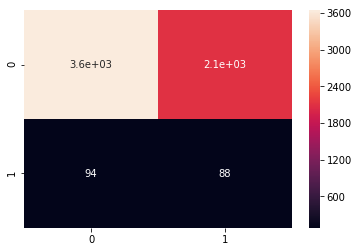

In [40]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

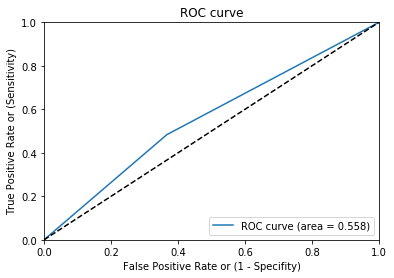

In [41]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = np.trapz(tpr,fpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC curve')
plt.legend(loc="lower right")

The logistic regression classifier didn't work that well; even though during training I tried to account for class imbalance by generating artificial samples with SMOTE, it seems that the playlist-level features aren't the most informative. My model has an overall f-score of 0.747, which hides the class imbalance issue of an f-score of 0.07 in the minority (collaborative) class. Additionally, my ROC AUC is only 0.558 (chance is 0.5).

Looking at the coefficients of my model, though, number of artists is the most informative feature, followed by the number of edits, tracks, and followers respectively. Note that after removing my multicollinear features (num of albums and playlist duration) I drastically improved my model (in checkpoint.ipynb I didn't remove these features, resulting in an f-score of only 0.24 and a ROC AUC of 0.532).